In [ ]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgbb

In [ ]:
from operator import index
data=pd.read_csv("model.csv",index_col="train_id")

In [ ]:
data.head()

,Unnamed: 0,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,,
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
data.shape

(50001, 8)

In [ ]:
data.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
49996,Camel Print Suede Leggings SPRING ITEM,1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,11.0,1,Absolutely gorgeous faux suede leggings! BRAND...
49997,Toddler Girls Zip-Up Gladiator Sandals,3,Kids/Girls 2T-5T/Shoes,NaN,8.0,1,Size 8. Excellent condition. Zip ups in the ba...
49998,[rm]--(2)Bundles for this price,1,NaN,Virgin Only,75.0,1,◇◇2 bundle Any length/FREE SHIPPING ◇◇¿¿¿¿¿◇Sa...


In [ ]:
data.shape

(50001, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50001 entries, 0 to 50000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               50001 non-null  object 
 1   item_condition_id  50001 non-null  int64  
 2   category_name      49764 non-null  object 
 3   brand_name         28417 non-null  object 
 4   price              50001 non-null  float64
 5   shipping           50001 non-null  int64  
 6   item_description   50001 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 3.1+ MB


In [ ]:
data.price.describe()

count    50001.000000
mean        26.652837
std         38.209339
min          0.000000
25%         10.000000
50%         17.000000
75%         29.000000
max       1506.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

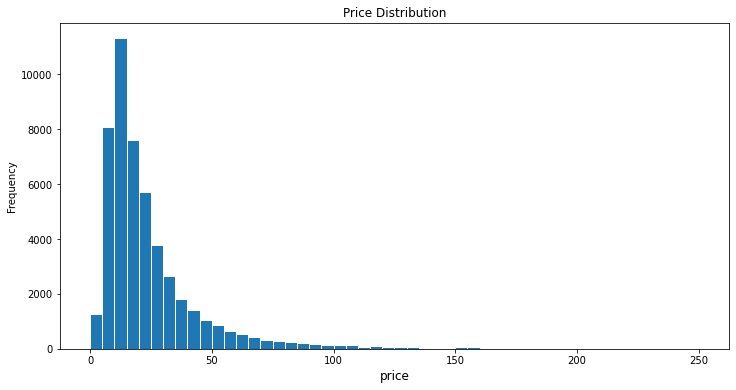

In [ ]:
(data['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)


Text(0.5, 1.0, 'Price Distribution')

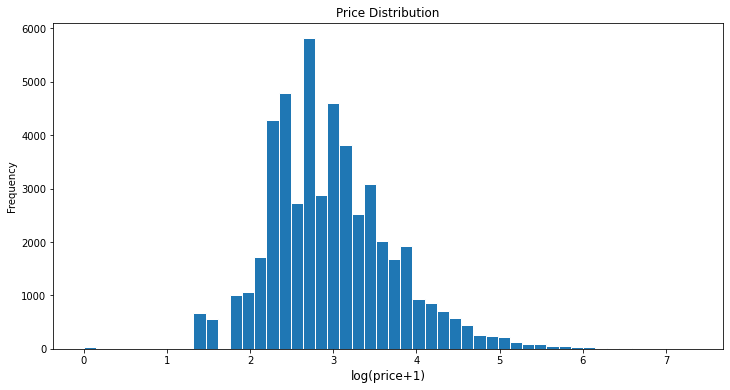

In [ ]:
np.log(data['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [ ]:
#The price of items are left skewed, vast majority of items priced at 10-20. However, the most expensive item priced at 2009. So we make log-transformation on the price.

In [ ]:
data["item_condition_id"].value_counts()

1    21574
3    14532
2    12706
4     1093
5       96
Name: item_condition_id, dtype: int64

In [ ]:
data[data["item_condition_id"]==5]

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
653,Fossil vintage renewal purse,5,Women/Women's Handbags/Shoulder Bag,Fossil,36.0,0,No description yet
1027,Broken necklace,5,Women/Jewelry/Necklaces,NaN,20.0,1,"10k gold 18"" chain. Broken at clasp."
2436,Gameboy advance sp ags-101 FOR PARTS,5,Other/Other/Other,NaN,24.0,0,For parts . Turns on and hold battery charge ....
2803,"2 Pounds Of ""Junk"" Jewelry",5,Handmade/Jewelry/Jewelry,NaN,11.0,0,"2 pounds of junk jewelry, There are some items..."
...,...,...,...,...,...,...,...
48250,Samsung galaxy core prime unlocked,5,Electronics/Cell Phones & Accessories/Cell Pho...,Samsung,18.0,1,Samsung galaxy core prime unlocked has a crack...
48351,American girl dolls,5,Kids/Toys/Dolls & Accessories,American Boy & Girl,119.0,0,"3 TLC dolls, They all have shine marks, Josefi..."
48991,Samsung prevail 8g android parts only,5,Electronics/Cell Phones & Accessories/Cell Pho...,Samsung,10.0,1,Samsung prevail still works perfectly (camera ...


In [ ]:
data["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings                 2018
Women/Tops & Blouses/T-Shirts                                  1541
Beauty/Makeup/Face                                             1161
Beauty/Makeup/Lips                                             1039
Electronics/Cell Phones & Accessories/Cases, Covers & Skins     888
                                                               ... 
Home/Bath/Other                                                   1
Vintage & Collectibles/Home Decor/Candle Holder                   1
Vintage & Collectibles/Book/Children                              1
Home/Home Appliances/Microwaves                                   1
Electronics/Cell Phones & Accessories/Other                       1
Name: category_name, Length: 881, dtype: int64

In [ ]:
data["brand_name"].value_counts()

PINK                       1876
Nike                       1783
Victoria's Secret          1554
LuLaRoe                    1056
Apple                       591
                           ... 
Exo-Terra                     1
Furminator                    1
Perry Ellis                   1
Warner Brothers               1
Beverly Hills Polo Club       1
Name: brand_name, Length: 1538, dtype: int64

In [ ]:
data["shipping"].value_counts()/len(data)

0    0.551669
1    0.448331
Name: shipping, dtype: float64

- Over 55% of items shipping fee were paid by the buyers. How shipping related 

1.   List item
2.   List item

to price?

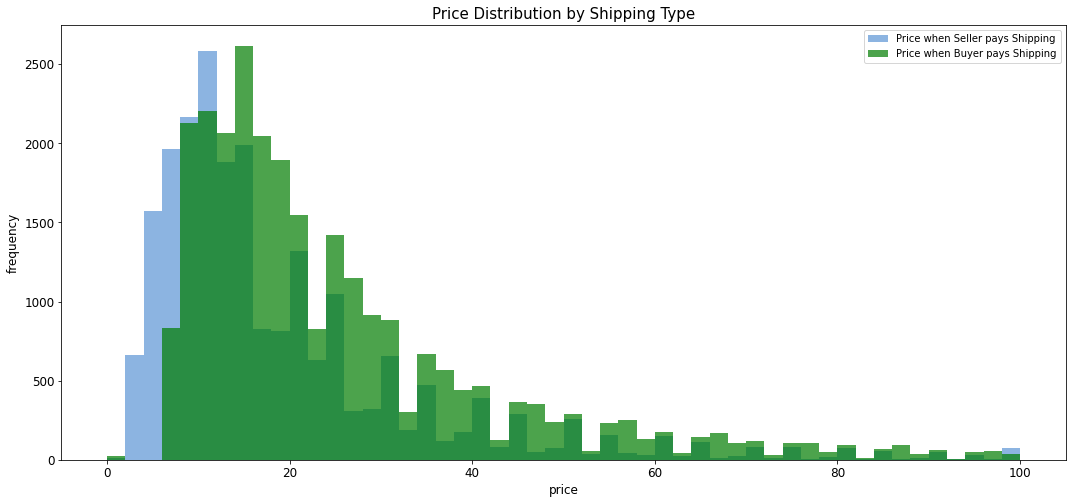

In [ ]:
shipping_fee_by_buyer = data.loc[data['shipping'] == 0, 'price']
shipping_fee_by_seller = data.loc[data['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [ ]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.42 if seller pays shipping
The average price is 30.09 if buyer pays shipping


- We compare again after log-transformation on the price.

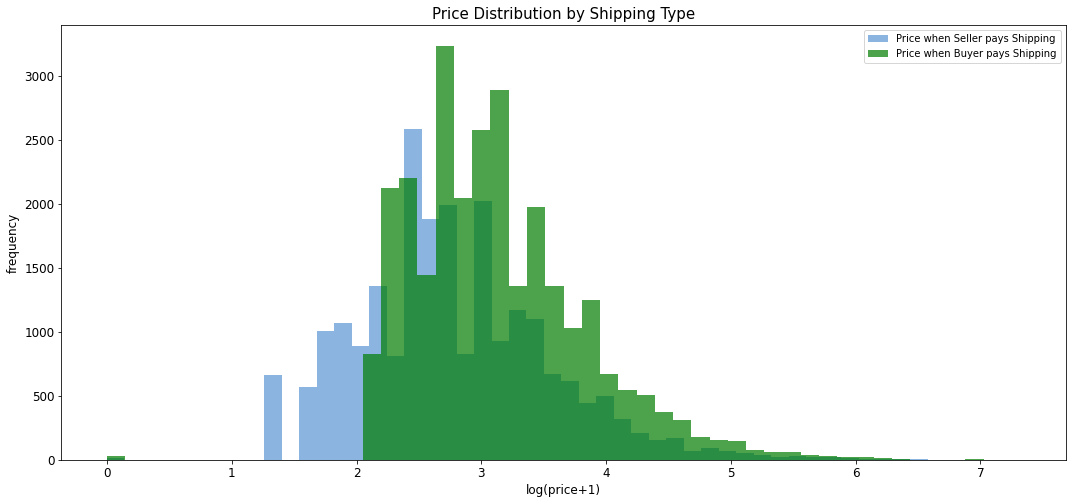

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

its obvious that price is higher if buyer pays shipping

## Category names

In [ ]:
print('There are', datab['category_name'].nunique(), 'unique values in category name column')

There are 881 unique values in category name column


In [ ]:
data['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 2018
Women/Tops & Blouses/T-Shirts                                  1541
Beauty/Makeup/Face                                             1161
Beauty/Makeup/Lips                                             1039
Electronics/Cell Phones & Accessories/Cases, Covers & Skins     888
Beauty/Makeup/Eyes                                              881
Electronics/Video Games & Consoles/Games                        844
Women/Underwear/Bras                                            728
Women/Tops & Blouses/Tank, Cami                                 713
Women/Athletic Apparel/Shorts                                   688
Name: category_name, dtype: int64

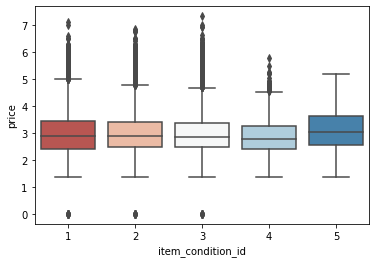

In [ ]:
sns.boxplot(x = 'item_condition_id', y = np.log(data['price']+1), data = data, palette = sns.color_palette('RdBu',5))


In [ ]:
print('There are %d items that do not have a category name.' %data['category_name'].isnull().sum())

There are 237 items that do not have a category name.


In [ ]:
print('There are %d items that do not have a brand name.' %data['brand_name'].isnull().sum())

There are 21584 items that do not have a brand name.


In [ ]:
print('There are %d items that do not have a description.' %data['item_description'].isnull().sum())


There are 0 items that do not have a description.


In [ ]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [ ]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [ ]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [ ]:
data= data[data.price != 0].reset_index(drop=True)

In [ ]:
data.shape

(49961, 7)

In [ ]:
x=data.drop(columns=["price"])
y=data["price"]
train_x,test_x,train_y,test_y=train_test_split(x,y)

In [ ]:
train_x.shape

(37470, 6)

In [ ]:
test_x.shape

(12491, 6)

In [ ]:
test_y.shape

(12491,)

In [ ]:
train_y.shape

(37470,)

In [ ]:
test_y= np.log1p(test_y)

In [ ]:
train_y= np.log1p(train_y)

In [ ]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [ ]:
merge: pd.DataFrame = pd.concat([train_x, test_x])

In [ ]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [ ]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [ ]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [ ]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [ ]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [ ]:
X_dummies = pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True)

In [ ]:
X_dummies.dtypes

shipping                          int64
item_condition_id_1    Sparse[uint8, 0]
item_condition_id_2    Sparse[uint8, 0]
item_condition_id_3    Sparse[uint8, 0]
item_condition_id_4    Sparse[uint8, 0]
item_condition_id_5    Sparse[uint8, 0]
dtype: object

In [ ]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_conditibon_id', 'shipping']], sparse=True).values)

In [ ]:
sparse_merge = hstack(( X_dummies,X_description, X_brand, X_category, X_name)).tocsr()


In [ ]:
sparse_merge.shape


(49961, 54966)

remove the features with document frequency less than 1

In [ ]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [ ]:
sparse_merge.shape

(49961, 54111)

In [ ]:
X = sparse_merge[:len(train_x)]
X_test = sparse_merge[len(train_x):]

In [ ]:
train_X = lgb.Dataset(X, label=train_y)

In [ ]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }


In [ ]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


In [ ]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(test_y, y_pred) ** 0.5)

The rmse of prediction is: 0.582625956002516
